# 12 Review of rampup-v3 with A2C

The observation in v3 is changed because it is not neccessary to provide the entire demand array. A preprocessed datum can compress all required information and discard irrelevant details. Information on precise demand is moved from the observation space to the info bit of `step()`.

In [1]:
import os
import subprocess
import webbrowser

from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

from plan_opt.create import env_cb_creator
from plan_opt.demand import Demand
from plan_opt.demand_small_samples import four_weeks_uprising
from plan_opt.env_health import env_health
from plan_opt.train_eval3 import train_and_evaluate

With default policy settings, training is worse and less stable.

In [2]:
config = {
    # ENVIRONMENT CONFIGURATION
    "ENV_ID": "rampup-v3",
    "REWARD_THRESHOLD": 80,
    "PUNISH_ILLEGAL": True,
    # WORKFLOW CONFIGURATION
    "TENSORBOARD_LOG": "logs/rampup_tensorboard/",
    "TIMESTEPS": 100000,
    "REPETITIONS": 15,
    "EVAL_EPISODES": 50,
    "SHOW_TABLE": False,
    "LEARNING_RATE": 0.0007,
    "POLICY_KWARGS": {
        "optimizer_class": RMSpropTFLike,
        "optimizer_kwargs": {"alpha": 0.99, "eps": 1e-8, "weight_decay": 0,},
    },
}

In [3]:
tb_suffix = ""
tb_suffix += f"_{str(config['TIMESTEPS'])[:-3]}k"
if config["PUNISH_ILLEGAL"]:
    tb_suffix += f"_legal_chg"
tb_suffix

'_100k_legal_chg'

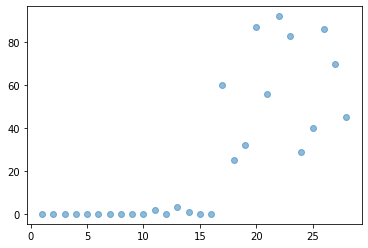

In [4]:
demand_4W = Demand(period=len(four_weeks_uprising), data=four_weeks_uprising)
env_4W, eval_callback_4W, demand_4W = env_cb_creator(config, demand_4W)

### Quick Health Check
- The observation is much neater compared to earlier versions

In [5]:
env_health(config, env_4W, first_step=False, random_steps=3, verbose=0)

Random step:	 0
Timestep:	 23 
Action:		 1 
Demand:		 29 
Reward:		 -2000 
Done:		 False 
Info:		 
  timestep_change          22 -> 23
  action_change            2 -> 1
  demand_surrounding       [83]-NOW(29)-[40 86 70]
  next_profitable_demand   2
  demand_observation       0.5 
Shape:		 (5,) 
Observation:
 [0.5 0.  1.  0.  0. ] 

Random step:	 1
Timestep:	 24 
Action:		 2 
Demand:		 40 
Reward:		 -1000 
Done:		 False 
Info:		 
  timestep_change          23 -> 24
  action_change            1 -> 2
  demand_surrounding       [29]-NOW(40)-[86 70 45]
  next_profitable_demand   1
  demand_observation       1.0 
Shape:		 (5,) 
Observation:
 [1. 0. 0. 1. 0.] 

Random step:	 2
Timestep:	 11 
Action:		 3 
Demand:		 0 
Reward:		 -500 
Done:		 False 
Info:		 
  timestep_change          10 -> 11
  action_change            0 -> 3
  demand_surrounding       [2]-NOW(0)-[3 1 0]
  next_profitable_demand   8
  demand_observation       0.125 
Shape:		 (5,) 
Observation:
 [0.125 0.    0.    0.    1.   ] 

### Train and Evaluate
Results look much more promising, as illegal moves are clearly learned and avoided. There are significant differences between repetitions!

In [ ]:
best_model, train_env, eval_env = train_and_evaluate(
    config=config,
    train_env=env_4W,
    eval_env=env_4W,
    eval_callback=eval_callback_4W,
    tb_log_name=f"A2C_train4W_eval4W_{tb_suffix}",
)


Running repetition 1/15...
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		35640.0
Standard deviation:	15925.463886493228
Economic potential:	41000
Lost potential:		5360.0 (13.0732%)

Running repetition 2/15...
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		28170.0
Standard deviation:	20689.27499938072
Economic potential:	41000
Lost potential:		12830.0 (31.2927%)

Running repetition 3/15...
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		23060.0
Standard deviation:	10916.79440128832
Economic potential:	41000
Lost potential:		17940.0 (43.7561%)

Running repetition 4/15...
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		36460.0
Standard deviation:	15712.682775388803
Economic potential:	41000
Lost potential:		4540.0 (11.0732%)

Running repetition 5/15...
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		25580.0
Standard deviation:	10030.633080718286
Economic potential:	41000
Lost potential:		15420.0 (37.6098%)

Run

15 repetitions over 150k episodes show results with variance remaining when applying the models!

![Evaluation](docs/nb12-eval.png)

### Tensorboard

In [ ]:
if 1 == 1:
    pid = subprocess.Popen(
        ["tensorboard", "--logdir", f"./{config['TENSORBOARD_LOG']}", "--port", "6006"]
    )
    os.system("sleep 5")
    webbrowser.open("http://localhost:6006")

In [ ]:
if 1 == 0:
    os.system("kill -9 $(lsof -t -i:6006)")